# Plot latent space of scDeepCluster

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import scanpy as sc
from collections import OrderedDict

sc.logging.print_version_and_date()
sns.set(style='white', context='notebook', rc={'figure.figsize': (9, 5)})
np.random.seed(42)

Running Scanpy 1.5.1, on 2020-07-12 06:23.


Load the latent embedding from scDeepCluster and the annotations file from cellassign:

In [2]:
E13_hom_latent_data = pd.read_csv('./exp_04/variable_genes/E13_hom_latent_output.csv', header=None)
# E13_hom_labels = pd.read_csv('../data_qc/anno_E13_hom.csv')

In [3]:
E14_hom_latent_data = pd.read_csv('./exp_04/variable_genes/E14_hom_latent_output.csv', header=None)
# E14_hom_labels = pd.read_csv('../data_qc/anno_E14_hom.csv')

In [4]:
print(E13_hom_latent_data.shape)
print(E14_hom_latent_data.shape)

(6222, 32)
(4263, 32)


In [5]:
# label_mapping_dict = {
#     'Neural progenitors': 1,
#     'Intermediate progenitors': 2,
#     'Post-mitotic neurons': 3,
#     'Ectopic cells': 4
# }

# E13_hom_num_labels = E13_hom_labels['cell_type'].map(label_mapping_dict)
# E14_hom_num_labels = E14_hom_labels['cell_type'].map(label_mapping_dict)

Load datasets after being preprocessing using quality control:

In [6]:
# E13_hom = pd.read_csv('../data_qc/E13_hom.csv')
# E13_hom = E13_hom.T
# E13_hom_data = E13_hom.reset_index(drop=True)
# E13_hom_data = E13_hom_data.div(E13_hom_data.sum(axis=1), axis=0)  # Normalise counts per cell

In [7]:
# E14_hom = pd.read_csv('../ann_data/E14_hom_no_cc.csv', index_col=0)
# E14_hom = E14_hom.T
# E14_hom_data = E14_hom.reset_index(drop=True)
# E14_hom_data = E14_hom_data.div(E14_hom_data.sum(axis=1), axis=0)  # Normalise counts per cell

In [8]:
E13_hom = sc.read_h5ad('../ann_data/exp_04/E13_hom_norm_variable_genes.h5ad')
E13_hom = E13_hom.to_df()
print(E13_hom.shape)

(6222, 1722)


In [9]:
E14_hom = sc.read_h5ad('../ann_data/exp_04/E14_hom_norm_variable_genes.h5ad')
E14_hom = E14_hom.to_df()
print(E14_hom.shape)

(4263, 2410)


In [10]:
neural_progenitors = ['Pax6', 'Vim', 'Sox2']
intermediate_progenitors = ['Eomes', 'Btg2']
post_mitotic_neurons = ['Tbr1', 'Sox5']

major_cell_types = neural_progenitors + intermediate_progenitors + post_mitotic_neurons

ectopic = ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']

Functions to run and plot UMAP:

In [11]:
def draw_umap(data, labels, n_neighbors=5, min_dist=0.99, n_components=2,
              metric='euclidean', title='', cmap='tab10', legend_title='Cell type'):
    
    np.random.seed(42)
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], range(len(u)), c=labels, cmap=cmap, marker='.')
    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], u[:,1], c=labels or None, cmap=cmap, marker='.')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(u[:,0], u[:,1], u[:,2], c=labels, s=100, cmap=cmap, marker='.')
    
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title=legend_title)
    ax.add_artist(legend1)
    plt.title(title, fontsize=24)

In [12]:
def fit_umap(latent_data, n_neighbors=5, min_dist=0.8, n_components=2, metric='euclidean'):
    np.random.seed(42)
    umap_fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = umap_fit.fit_transform(latent_data)
    return embedding    

In [13]:
def plot_umap_for_markers(embedding, orig_data, labels, n_neighbors=5, min_dist=0.8, n_components=2,
                          metric='euclidean', title='', cmap='tab10', show_legend=True):

    len_labels = len(labels)
    fig_size = (15, 30) if len_labels < 10 else (15, 45)
    fig = plt.figure(figsize=fig_size)
    
    # Create subplots
    subplot_idx = 1
    for i, v in enumerate(range(len_labels)):
        if labels[i] in orig_data:
            ax = fig.add_subplot(len_labels, 3, subplot_idx)
            scatter = ax.scatter(embedding[:,0], embedding[:,1], c=orig_data[labels[i]], cmap=cmap, marker='.')
            plt.title(labels[i], fontsize=15)
            subplot_idx = subplot_idx + 1
        

Followed this tutorial: https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

In [14]:
def cell_cycle_phase(dataset, min_dist=0.1):
    # Get cell cycle scores and phases from the initial dataset and use the phases to plot the latent space
    
    # Load initial dataset (after qc and pre-normalisation - the one we feed to the AE) and the list
    # of predefined cell cycle genes
    adata = sc.AnnData(X=dataset)
    print('Initial dataset', adata.shape)
    cell_cycle_genes = [x.strip().lower().capitalize() for x in open('../preprocessing/regev_lab_cell_cycle_genes.txt')]

    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    cc_phase = adata.obs.phase

    adata_cc_genes = adata[:, cell_cycle_genes]
    
    # Check if cells are separated by their cell cycle phase when cell cycle genes are used
    mapping = {'G1': 1, 'S': 2, 'G2M': 3}
    cc_phase_num = [mapping[i] for i in list(cc_phase)]
    draw_umap(adata_cc_genes.X,  cc_phase_num, legend_title='Cell cycle phase',
              title='Initial dataset', min_dist=min_dist)


    # Strong effect of cell cycle effect -> unwanted variation -> regress out
    sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
    sc.pp.scale(adata)

    # Replot umap withe cell cycle genes to check that the phase has been regressed out
    adata_cc_genes = adata[:, cell_cycle_genes]
    # sc.tl.pca(adata_cc_genes)
    # sc.pl.pca_scatter(adata_cc_genes, color='phase')
    draw_umap(adata_cc_genes.X,  cc_phase_num, legend_title='Cell cycle phase',
              title='After regressing out the phase', min_dist=min_dist)
    
    
    return cc_phase_num

## E13_HOM dataset

### Initial dataset (normalised):

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


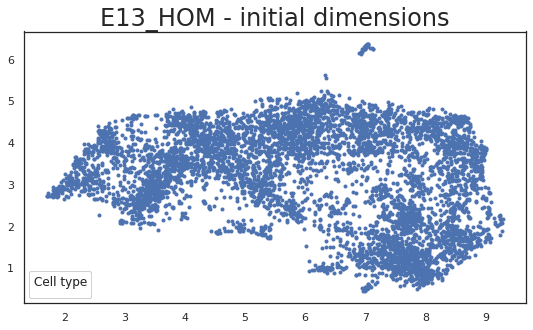

In [15]:
draw_umap(E13_hom, [], min_dist=0.001, title='E13_HOM - initial dimensions')

### Plot latent space using the cell type annotations:

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


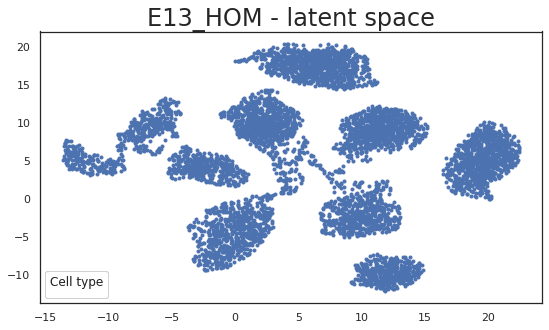

In [16]:
draw_umap(E13_hom_latent_data, [], min_dist=0.8, title='E13_HOM - latent space')

### Plot latent space using the gene markers for each cell type:

In [17]:
E13_hom_embedding = fit_umap(E13_hom_latent_data)

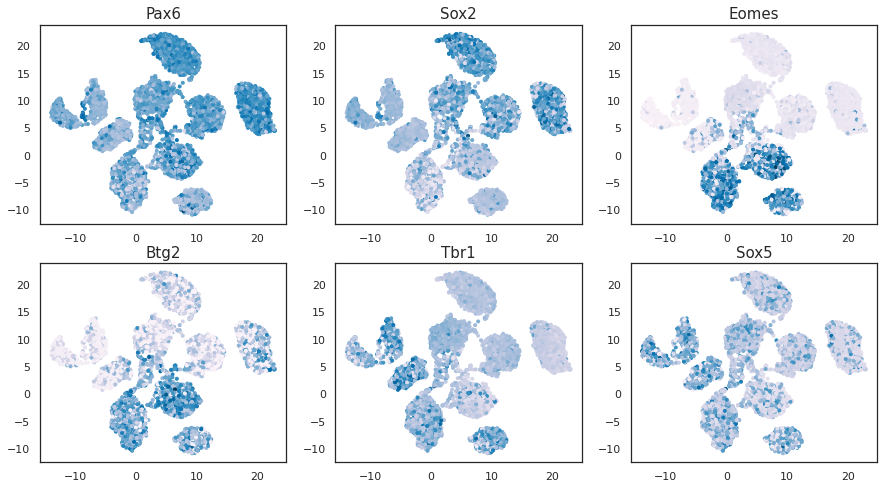

In [18]:
plot_umap_for_markers(E13_hom_embedding, E13_hom, major_cell_types, cmap='PuBu')

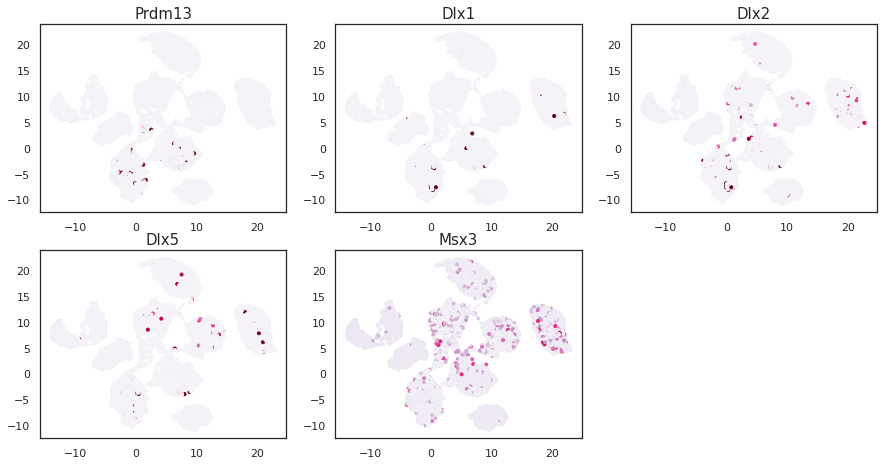

In [19]:
plot_umap_for_markers(E13_hom_embedding, E13_hom, ectopic, cmap='PuRd')

### Check cell cycle phase

Plot UMAP for the initial dataset using the cell cycle phases:

Initial dataset (6222, 1722)


... storing 'phase' as categorical


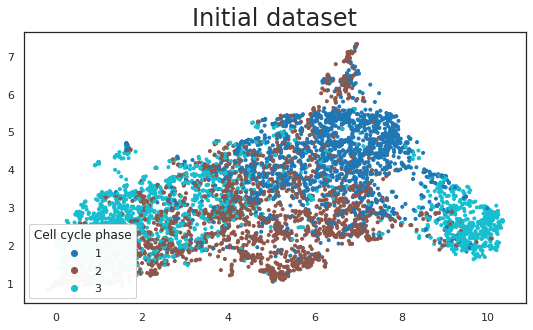

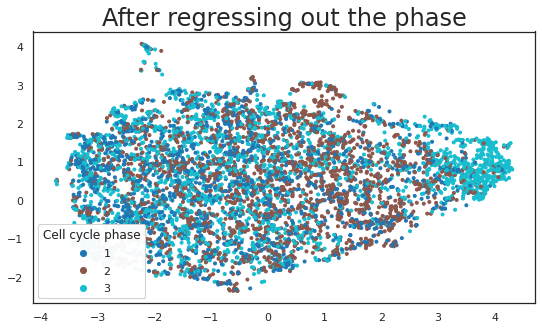

In [20]:
cell_cycle_phases_E13 = cell_cycle_phase(E13_hom, min_dist=0.001)

Plot UMAP for the latent space using the cell cycle phases:

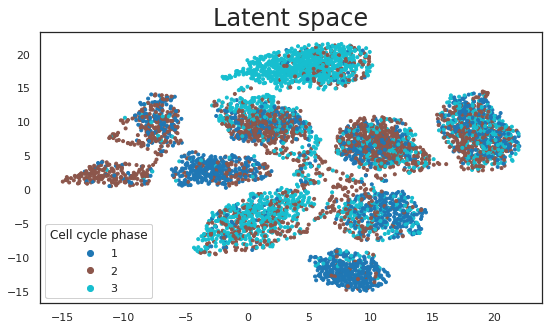

In [21]:
draw_umap(E13_hom_latent_data, cell_cycle_phases_E13, legend_title='Cell cycle phase', title='Latent space')

## E14_HOM  dataset

### Initial dataset:

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


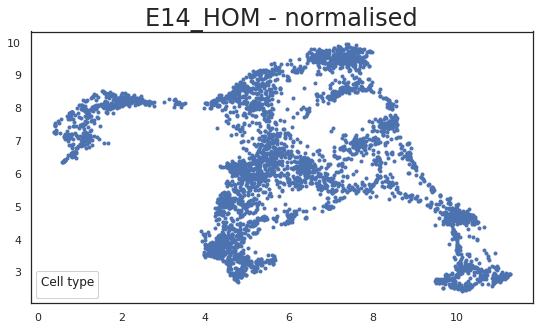

In [22]:
draw_umap(E14_hom, [], min_dist=0.01, title='E14_HOM - normalised')

### Plot latent space using the cell type annotations:

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


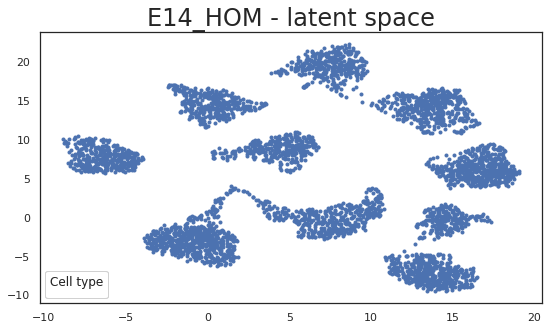

In [23]:
draw_umap(E14_hom_latent_data, [], min_dist=0.7, title='E14_HOM - latent space')

### Plot latent space using the gene markers for each cell type:

In [24]:
E14_hom_embedding = fit_umap(E14_hom_latent_data, min_dist=0.7)

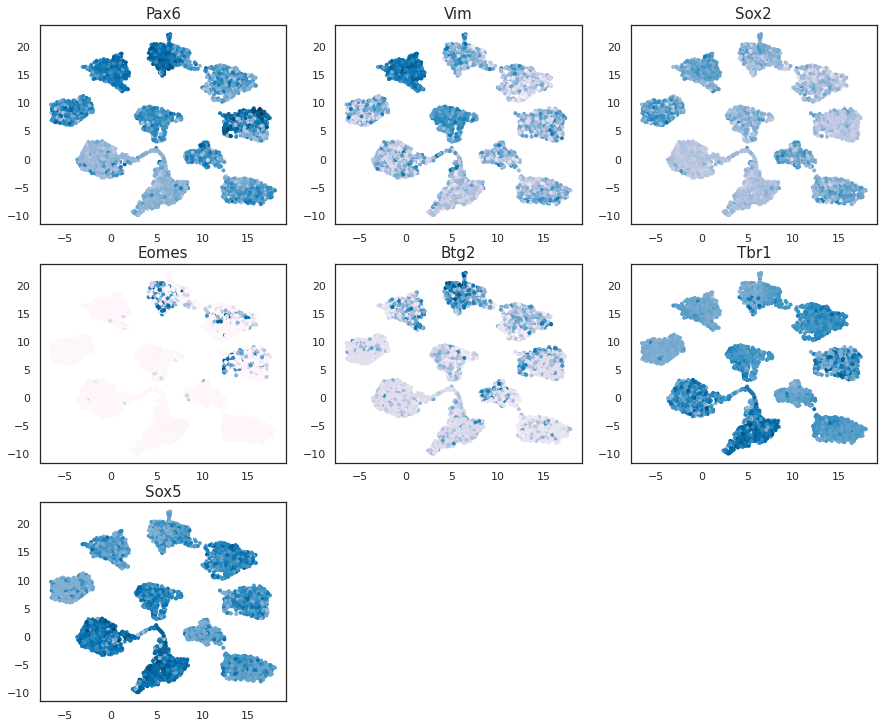

In [25]:
plot_umap_for_markers(E14_hom_embedding, E14_hom, major_cell_types, cmap='PuBu')

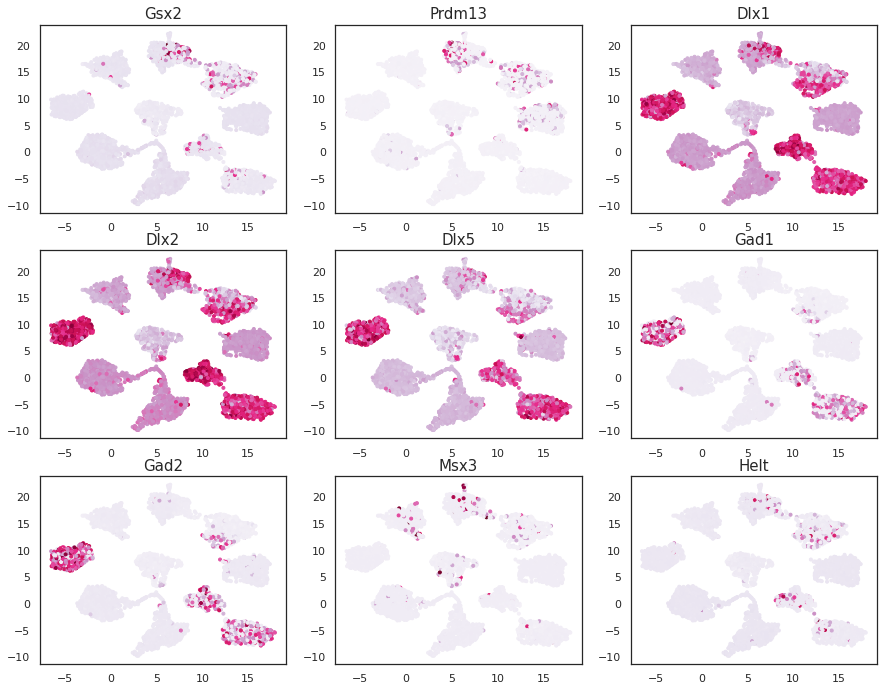

In [26]:
plot_umap_for_markers(E14_hom_embedding, E14_hom, ectopic, cmap='PuRd')

### Check cell cycle phase

Plot UMAP for the initial dataset using the cell cycle phases:

Initial dataset (4263, 2410)


... storing 'phase' as categorical


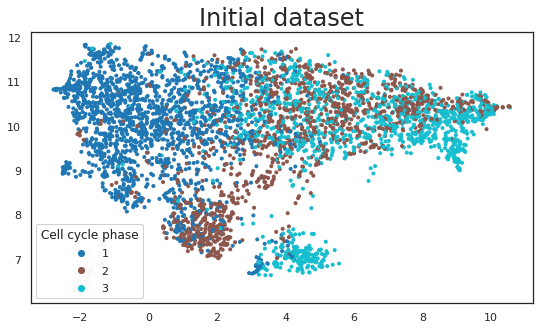

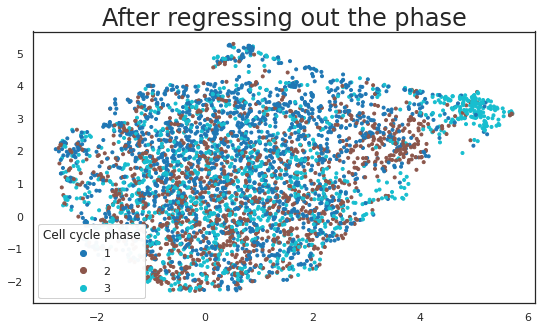

In [27]:
cell_cycle_phases_E14 = cell_cycle_phase(E14_hom)

Plot UMAP for the latent space using the cell cycle phases:

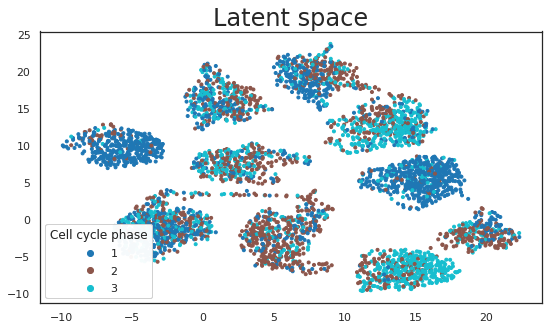

In [28]:
draw_umap(E14_hom_latent_data, cell_cycle_phases_E14, legend_title='Cell cycle phase', title='Latent space')